In [37]:
#!pip install pysal h3

**Define address**

In [38]:
# 2 bed, 1.5 bath property in Oakland
myEstate="466 Wesley Ave, Oakland, CA 94606"

In [39]:
#!pip install tobler

**Import data from Github**

City of Oakland boundary data from [oaklandca.gov](https://data.oaklandca.gov/Property/City-of-Oakland-City-Limits/9bhq-yt6w)

In [40]:
import pandas as pd
import geopandas as gpd

#Oakland Border shapefile
linkOaklandBorder="https://raw.githubusercontent.com/eamonmadden-sketch/Homework-2/main/Oakland_City_Limits_20251104.zip"
Oakland=gpd.read_file(linkOaklandBorder)

#Listings from insideairbnb
linkOaklandAirbnb="https://raw.githubusercontent.com/eamonmadden-sketch/Homework-2/main/detailed_Oakland_listings.csv"
airbnb_all=pd.read_csv(linkOaklandAirbnb)

**Prepare and map the data**

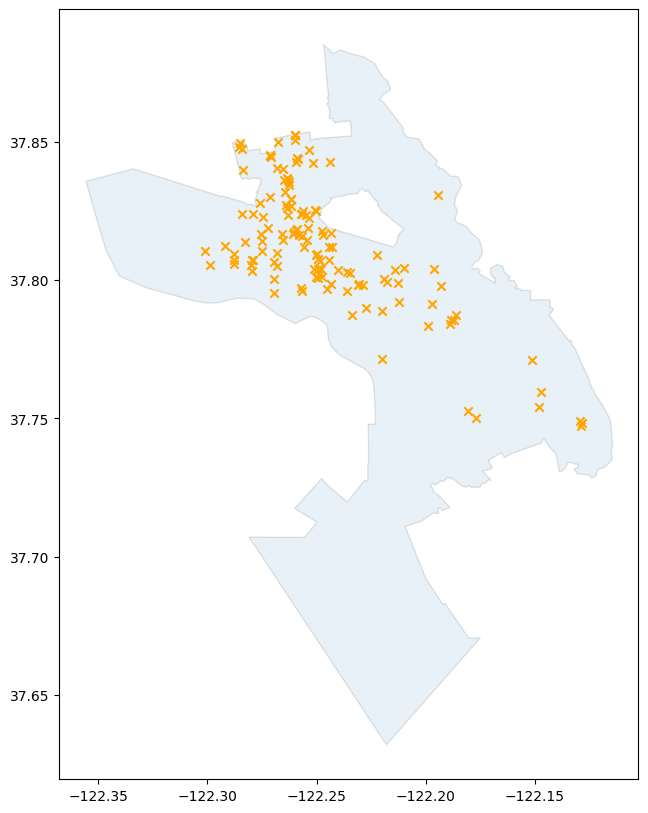

In [41]:
#Keep certiain fields only
keep=['id','price','bedrooms','property_type','latitude','longitude']
airbnb=airbnb_all[keep].copy()
airbnb.price.str.replace(r'\$|\,', '', regex=True).astype(float)
airbnb['price']=airbnb.price.str.replace(r'\$|\,', '', regex=True).astype(float)

#Drop NAs
airbnb.dropna(inplace=True)

#Specify type of bnb
pd.crosstab(airbnb.property_type,airbnb.bedrooms)
conditions="bedrooms==2 & property_type=='Entire rental unit'"
airbnb_source=airbnb.query(conditions).copy()

#Create the list to drop the duplicates
key_columns = ['latitude', 'longitude']

#Remove identical rows across  key columns
airbnb_source_unique = airbnb_source.drop_duplicates(subset=key_columns)

#Setup Geodataframe
source_gdf = gpd.GeoDataFrame(
    airbnb_source_unique,
    geometry=gpd.points_from_xy(airbnb_source_unique.longitude,
                                airbnb_source_unique.latitude),
    crs='EPSG:4326') #long / lat

source_gdf=source_gdf.to_crs(Oakland.crs)

#Make Airbnb locations map
base=Oakland.plot(figsize=(10,10),alpha=0.1,edgecolor='black')
source_gdf.plot(ax=base,marker="x",color='orange')

Oakland.to_file("Oakland.gpkg",driver='GPKG',layer='city_bounds')
source_gdf.to_file("Oakland.gpkg",driver='GPKG',layer='airbnb_locations')


**H3fy the data**

In [42]:
import tobler

#H3fy the Oakland shapefile
Oakland_grid10=tobler.util.h3fy(Oakland.to_crs(4326), resolution=10).to_crs(Oakland.crs)
Oakland_target_locations = Oakland_grid10.centroid.get_coordinates()

source_locations = source_gdf.get_coordinates()


/tmp/ipython-input-222719510.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Oakland_target_locations = Oakland_grid10.centroid.get_coordinates()


In [43]:
!pip install h3

**Outlining my different options for interpolation**



In [44]:
# Knn uniform - best fit for my data
from sklearn.neighbors import KNeighborsRegressor

interpolation_uniform = KNeighborsRegressor(n_neighbors=10,
                                            weights="uniform").\
                                            fit(source_locations,
                                                source_gdf.price)

Oakland_grid10["knn10_uniform"] = interpolation_uniform.predict(Oakland_target_locations)

#Oakland_grid10.plot("knn10_uniform", legend=True,figsize=(10,10))


# IDW

interpolation_IDW = KNeighborsRegressor(n_neighbors=10,
                                            weights="distance").\
                                            fit(source_locations,
                                                source_gdf.price)

Oakland_grid10["IDW_10"] = interpolation_IDW.predict(Oakland_target_locations)

#Oakland_grid10.plot("IDW_10", legend=True,figsize=(10,10))


# Nearest
from scipy.interpolate import griddata

Oakland_grid10["nearest"] = griddata(points=source_locations,
                                    values=source_gdf.price,
                                    xi=Oakland_target_locations,
                                    method="nearest")

#Oakland_grid10.plot('nearest', legend=True,figsize=(10,10))


# Radius 1000
from sklearn.neighbors import RadiusNeighborsRegressor

interpolation_radius = RadiusNeighborsRegressor(
    radius=1000, weights="distance"
)
interpolation_radius.fit(
    source_locations, source_gdf.price
)

Oakland_grid10["radius_1000"] = interpolation_radius.predict(Oakland_target_locations)

#Oakland_grid10.plot("radius_1000", legend=True, missing_kwds={'color': 'lightgrey'},figsize=(10,10))

**Finding out how much to charge using a map**

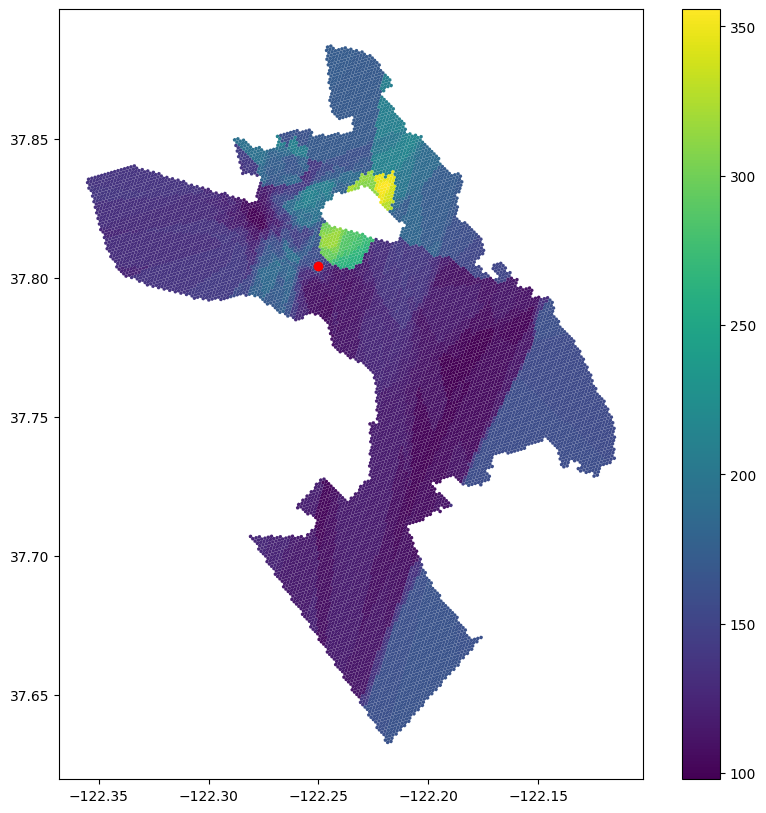

In [46]:
from geopy.geocoders import Nominatim
from shapely.geometry import Point

# Use geolocator
geolocator = Nominatim(user_agent="theGeocoder")
myEstate_Address = geolocator.geocode(myEstate)

MyEstate_gdf4326 = gpd.GeoDataFrame(
    {'address': [myEstate_Address.address]},
    geometry=[Point(myEstate_Address.longitude, myEstate_Address.latitude)],
    crs="EPSG:4326" # because of lon/lat
)

# Reproject the etstate to the city and use a spatial join
MyEstate_gdf = MyEstate_gdf4326.to_crs(Oakland.crs)

MyEstate_gdf.sjoin(
    Oakland_grid10,
    how="left",
    predicate="within"
)

# Plot!
base=Oakland_grid10.plot("knn10_uniform", legend=True, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
MyEstate_gdf.plot(ax=base,color='red')

Oakland_grid10.to_file("Oakland.gpkg",driver='GPKG',layer='city_grid')
MyEstate_gdf.to_file("Oakland.gpkg",driver='GPKG',layer='myEstate')


In [47]:
MyEstate_gdf.sjoin(
    Oakland_grid10,
    how="left",
    predicate="within"
)

,address,geometry,hex_id,knn10_uniform,IDW_10,nearest,radius_1000
0,"466, Wesley Avenue, Cleveland Heights, Oakland...",POINT (-122.2503 37.80416),8a28308162b7fff,152.9,140.967036,142.0,159.613623
